In [65]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Image Enhancements

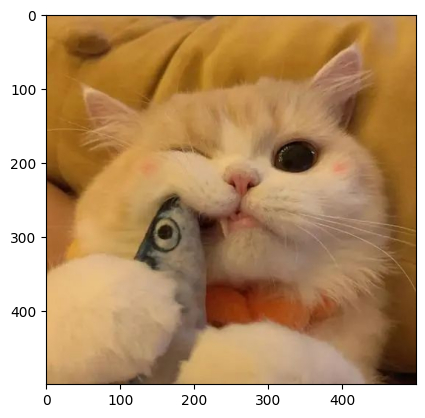

In [66]:
img_file = "maomao.jpg"
img = np.float32(cv2.imread(img_file, cv2.IMREAD_COLOR_RGB) / 255.0)
plt.imshow(img)
plt.show()

### Contrast Enhancement

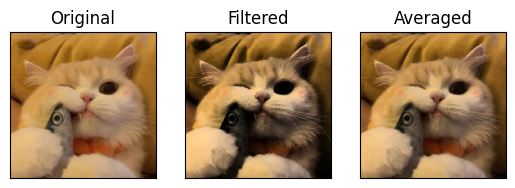

In [67]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_hsv[:, :, 2] = cv2.equalizeHist(np.uint8(img_hsv[:, :, 2] * 255)) / 255.0
img_fil = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

result = (img + img_fil)/2

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img)
axes[0].set_title("Original"), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(img_fil)
axes[1].set_title("Filtered"), axes[1].set_xticks([]), axes[1].set_yticks([])
axes[2].imshow(result)
axes[2].set_title("Averaged"), axes[2].set_xticks([]), axes[2].set_yticks([])
plt.show()

### Color Enhancement

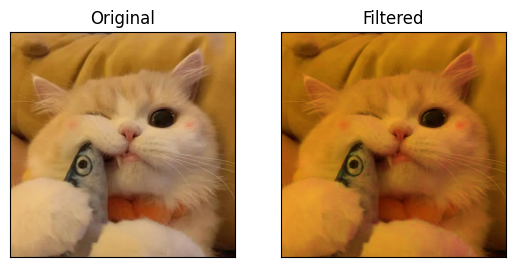

In [68]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_hsv[:, :, 1] = np.power(img_hsv[:, :, 1], 1/4)
img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1], 0, 1.0)
img_fil = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img)
axes[0].set_title("Original"), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(img_fil)
axes[1].set_title("Filtered"), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()

### Color Shift

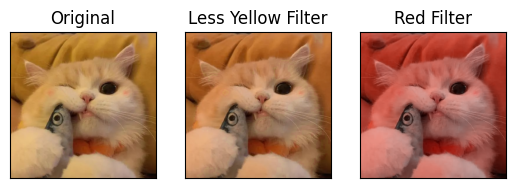

In [69]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
img_hsv[:, :, 0] *= 0.2
img_hsv[:, :, 0] = np.clip(img_hsv[:, :, 0], 0, 360)
img_red = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

img_hsv = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2HSV)
img_hsv[:,:,0][(img_hsv[:,:,0] > 30) & (img_hsv[:,:,0] < 65)] *= 0.75
img_hsv[:, :, 0] = np.clip(img_hsv[:, :, 0], 0, 360)
img_yel = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[0].set_title("Original")
axes[1].imshow(img_yel), axes[1].set_xticks([]), axes[1].set_yticks([])
axes[1].set_title("Less Yellow Filter")
axes[2].imshow(img_red), axes[2].set_xticks([]), axes[2].set_yticks([])
axes[2].set_title("Red Filter")
plt.show()

## Image Filters

##### Backend

Credit to [Greg Gundersen](https://github.com/gwgundersen/kernels/blob/master/kernels.py) for the base Kernel classes

In [70]:
"""Convolution matrices for image processing.
"""

import numpy as np


# Base class
# -----------------------------------------------------------------------------

class Kernel(object):

    def __init__(self, size=3):
        """Construct an image processing kernel. Most Kernel subclasses take
        `size` as an argument.

        Example for Gauss. Others are similar except the Kernel subclass and
        additional arguments.
        -------
        >>> import numpy as np
        >>> from PIL import Image
        >>> from kernels import Gauss
        >>> from scipy import misc
        >>> data = np.uint8(misc.lena())
        >>> kernel = Gauss()
        >>> filtered = kernel.convolve(data)
        >>> image = Image.fromarray(filtered)
        >>> image.show()
        """
        self.size = size

    def convolve(self, image, step=1):
        """Apply kernel to every pixel in image.
        """
        new_image = np.zeros(image.shape)
        center = int(np.floor(self.size / 2))
        offset = center
        for i in range(offset, new_image.shape[0]-offset, step):
            for j in range(offset, new_image.shape[1]-offset, step):
                X = image[i - offset:i + offset + 1, j - offset:j + offset + 1]
                new_image[i, j] = self.apply(X)
        return new_image

    def apply(self, X):
        """Apply single matrix convolution and normalize value to [0, 255].
        """
        value = (X * self._flip(self.K)).sum()
        return self._normalize(value)

    def _normalize(self, value):
        """Normalize value to range [0, 255].
        """
        return min(255, max(0, value))

    def _flip(self, X):
        """Flips a matrix twice, once over the horizontal and once over the
        vertical axes.

        Example
        -------
        >>> import numpy as np
        >>> X = np.array([[1, 2], [3, 4]])
        >>> X
        array([[1, 2],
               [3, 4]])
        >>> np.fliplr(np.flipud(X))
        array([[4, 3],
               [2, 1]])
        """
        return np.fliplr(np.flipud(X))


# Blur
# -----------------------------------------------------------------------------

class Mean(Kernel):

    def __init__(self, size=3):
        """The mean kernel for image blurring:

        [[ 1/9  1/9  1/9]
         [ 1/9  1/9  1/9]
         [ 1/9  1/9  1/9]]

        The mean kernel is perhaps the most intuitive. Replace each pixel with
        the average value of the pixel itself and its neighbors.
        """
        super().__init__(size)
        K = np.ones((size, size))
        K /= (size * size)
        self.K = K


class Gauss(Kernel):

    def __init__(self, size=3, sigma=1):
        """The Gaussian blur kernel, e.g. 3x3:

        [[ 0.07511361  0.1238414   0.07511361]
         [ 0.1238414   0.20417996  0.1238414 ]
         [ 0.07511361  0.1238414   0.07511361]]

        Weights a pixel and its neighbors by a 2-D Gaussian function. This
        produces a blur that is more subtle than mean blur.
        """
        super().__init__(size)
        self.sigma = sigma

        K = np.zeros((size, size))
        center = int(np.floor(self.size / 2))
        for x in range(-center, center+1):
            for y in range(-center, center+1):
                K[x+center, y+center] = self.gaussian(x, y)

        # Normalize so the image does not become darker as the size increases.
        K /= K.sum()
        # Gaussian kernel should be symmetric.
        assert (K == K.T).all()
        self.K = K

    def gaussian(self, x, y):
        """Return value from two-dimensional Gaussian function (x, y) is a
        point relative to the origin. (0, 0) is the center of the distribution.
        For more, see: https://en.wikipedia.org/wiki/Gaussian_blur.
        """
        return (1 / np.sqrt(2 * np.pi * self.sigma**2)) * \
               np.exp(-(x**2 + y**2) / (2 * self.sigma**2))


# Edge detection
# -----------------------------------------------------------------------------

class Laplace(Kernel):

    def __init__(self):
        """The Laplace kernel for edge detection:

        [[-1 -1 -1]
         [-1  8 -1]
         [-1 -1 -1]]

        If the sum of the neighbors' values is roughly equal to the center
        pixel's value, the kernel will return a number close to 0. If there is
        a strong differential in pixel values in the kernel, the center will be
        positive. Since white is typically taken to be 255 while black is taken
        to be 0, this will create an image of white edges on a dark field.
        """
        super().__init__()
        K = np.zeros((self.size, self.size))
        center = int(np.floor(self.size / 2))
        K[:,:] = -1
        # e.g. For a 3x3 matrix, the center cell's value is 8.
        K[center, center] = K.size - 1
        self.K = K


class Sobel(Kernel):

    def __init__(self):
        """The Sobel kernel for edge detection:

        [[-1  0  1]
         [-2  0  2]
         [-1  0  1]]

        [[ 1  2  1]
         [ 0  0  0]
         [-1 -2 -1]]

        The Sobel operation involves two kernels which approximate the
        derivatives in pixel values in the kernel, one for the horizontal
        and another for the vertical derivatives.
        """
        super().__init__()
        x = np.array([1, 2, 1])
        y = np.array([1, 0, -1])
        self.Ky = np.outer(y, x)
        self.Kx = np.rot90(self.Ky, k=3)

    def apply(self, X):
        """Overrides the Kernel super class's apply to approximate the Sobel
        gradient magnitude.
        """
        x = (X * self._flip(self.Kx))
        y = (X * self._flip(self.Ky))
        value = np.sqrt(x.sum()**2 + y.sum()**2)
        return self._normalize(value)


# Sharpen
# -----------------------------------------------------------------------------

class Sharpen(Kernel):

    def __init__(self):
        """Kernel for image sharpening:

        [[ 0 -1  0]
         [-1  5 -1]
         [ 0 -1  0]]

        Replaces the value of a pixel with a value slightly higher than the
        weighted sum of its neighbors.
        """
        super().__init__()
        K = np.zeros((self.size, self.size))
        center = int(np.floor(self.size / 2))
        K[center, :] = -1
        K[:, center] = -1
        K[center, center] = 5
        self.K = K

##### Try them out!

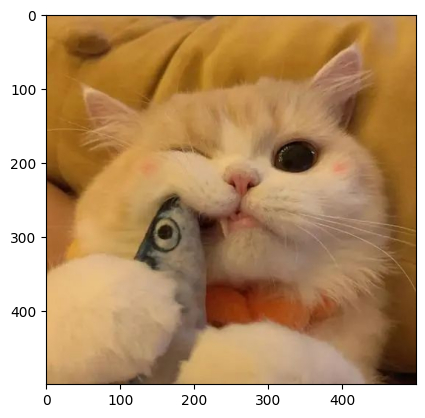

In [71]:
img_file = "maomao.jpg"
img = np.float32(cv2.imread(img_file, cv2.IMREAD_COLOR_RGB) / 255.0)
plt.imshow(img)
plt.show()

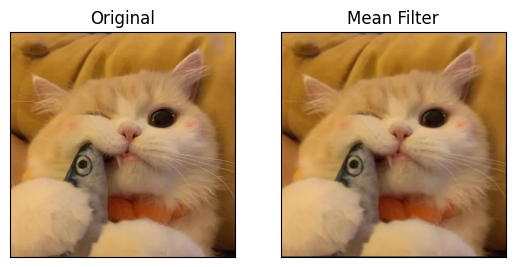

In [72]:
kernel = Mean()
img_fil = np.zeros_like(img)
for channel in range(3):
    img_fil[:,:,channel] = kernel.convolve(img[:,:,channel])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img)
axes[0].set_title("Original"), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(img_fil)
axes[1].set_title("Mean Filter"), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()

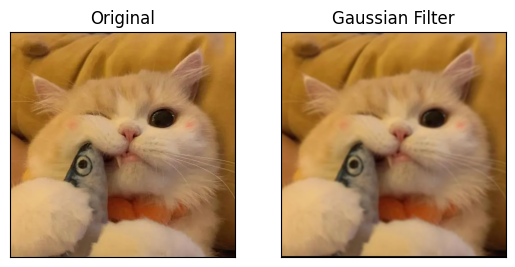

In [73]:
kernel = Gauss(size=5, sigma=3)
img_fil = np.zeros_like(img)
for channel in range(3):
    img_fil[:,:,channel] = kernel.convolve(img[:,:,channel])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img)
axes[0].set_title("Original"), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(img_fil)
axes[1].set_title("Gaussian Filter"), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()

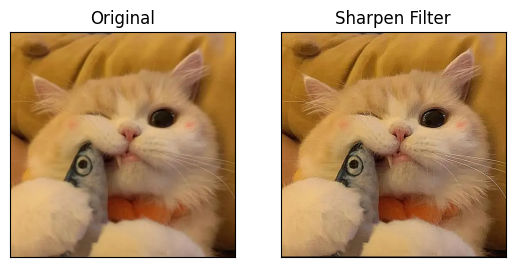

In [74]:
kernel = Sharpen()
img_fil = np.zeros_like(img)
for channel in range(3):
    img_fil[:,:,channel] = kernel.convolve(img[:,:,channel])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img)
axes[0].set_title("Original"), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(img_fil)
axes[1].set_title("Sharpen Filter"), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()

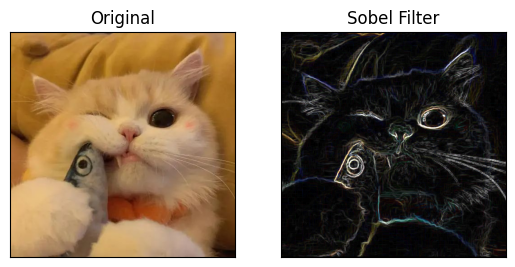

In [75]:
kernel = Sobel()
img_fil = np.zeros_like(img)
for channel in range(3):
    img_fil[:,:,channel] = kernel.convolve(img[:,:,channel])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img)
axes[0].set_title("Original"), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(img_fil)
axes[1].set_title("Sobel Filter"), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()

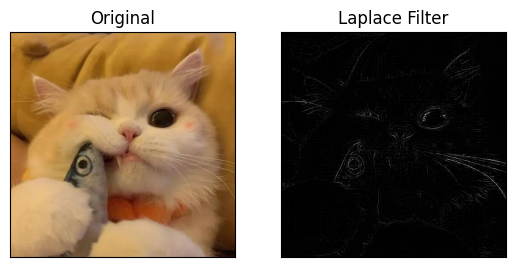

In [76]:
kernel = Laplace()
img_fil = np.zeros_like(img)
for channel in range(3):
    img_fil[:,:,channel] = kernel.convolve(img[:,:,channel])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img)
axes[0].set_title("Original"), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(img_fil)
axes[1].set_title("Laplace Filter"), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()